In [1]:
%load_ext autoreload
%autoreload 2

## Load `Llama 2` Model

This model is hosted on [HuggingFace](https://huggingface.co/microsoft/phi-2).

Requirements:
 * `transformers`
 * `datasets`
 * `torch`


In [2]:
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_default_device("cuda")

# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained("./llama-huggingface/llama-2-7b-chat", torch_dtype="auto") # , attn_implementation="flash_attention_2")
tokenizer = AutoTokenizer.from_pretrained("./llama-huggingface/llama-2-7b-chat") # , attn_implementation="flash_attention_2")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Inference

We'll use a small and quick dataset for testing: Winogrande. This is stored on [HuggingFace](https://huggingface.co/datasets/winogrande) as well. This returns a `DatasetDict` with the keys `train`, `test`, and `validation`. This can be indexed just like a Torch dataset. For Winogrande, each item contains the following indices:
 * `sentence`: `"A sentence with an _"`
 * `option{1, 2}`: Possible ways to fill in the blank
 * `answer`: `1` or `2` indicating the correct option


In [75]:
inputs = tokenizer("What is the capital of France? Respond in one word. Answer:", return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_new_tokens=2, output_hidden_states=True, return_dict_in_generate=True)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [79]:
# output_text_result = tokenizer.decode(outputs['sequences'][0][1:-1])

output_text_result = 'The capital of France is Paris.'
print(output_text_result)

The capital of France is Paris.


In [80]:
test_text = tokenizer(output_text_result, return_tensors="pt", return_attention_mask=False)

In [ ]:
inputs = tokenizer(
    "User: What is the University of Virginia? Please be as descriptive as possible.\nAssistant:", return_tensors="pt", return_attention_mask=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# A tuple of size (1 + num_layers), each with
# (batch_size, sequence_length, hidden_size)

outputs = model.forward(**test_text, output_hidden_states=True, output_attentions=True)
hidden_states = outputs.hidden_states
attentions = outputs.attentions

activations_grid = np.zeros((len(hidden_states), len(test_text['input_ids'][0])))

for layer_i in range(len(hidden_states)):
    batch_size, sequence_length, hidden_size = hidden_states[layer_i].shape
    for token_i in range(sequence_length - 1):
        target_token_id = test_text['input_ids'][0, token_i + 1]
        intermediate_logits = model.lm_head(hidden_states[layer_i][0, token_i])
        activations_grid[layer_i, token_i] = intermediate_logits[target_token_id]

# print(tokenizer.decode(inputs['input_ids'][0][15:21]))

plt.imshow(activations_grid)
plt.ylim(0, 32)
plt.title("Intermediate activations (color = likelihood)")
plt.xlabel("Sequence Index")
plt.ylabel("Layer number")
plt.colorbar()
plt.show()


Layer number: 0


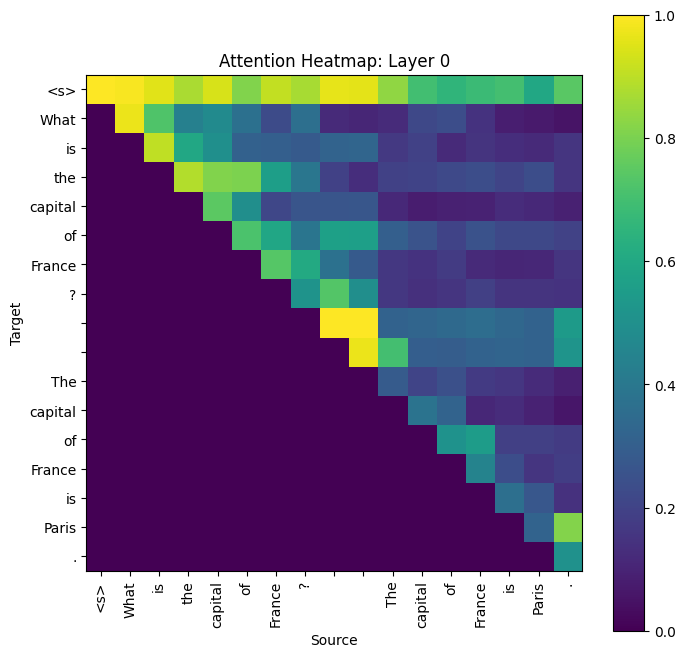

Layer number: 1


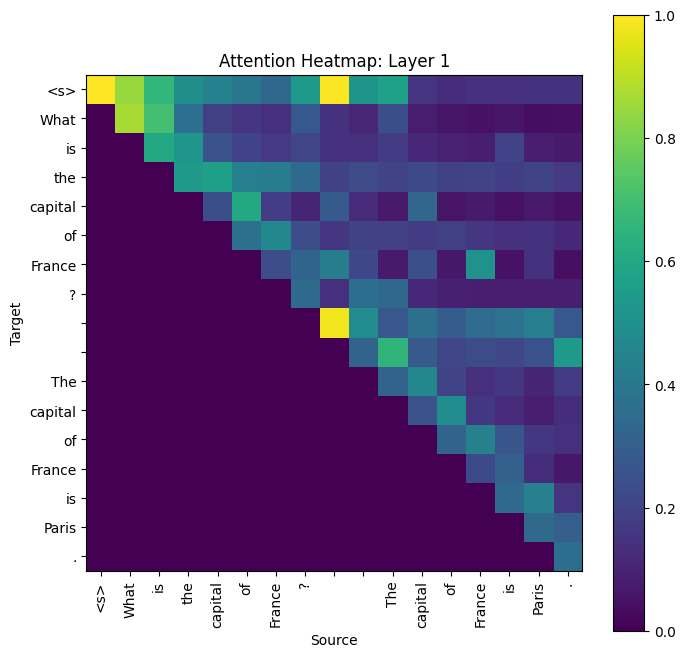

Layer number: 2


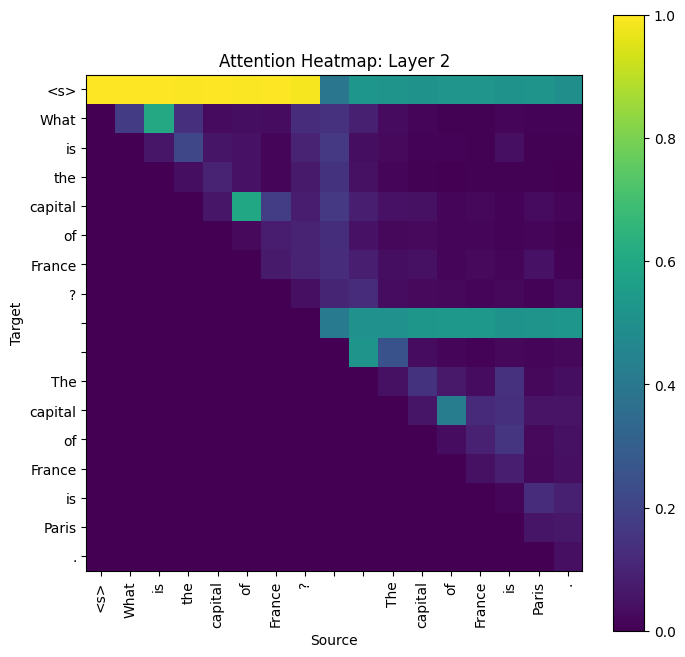

Layer number: 3


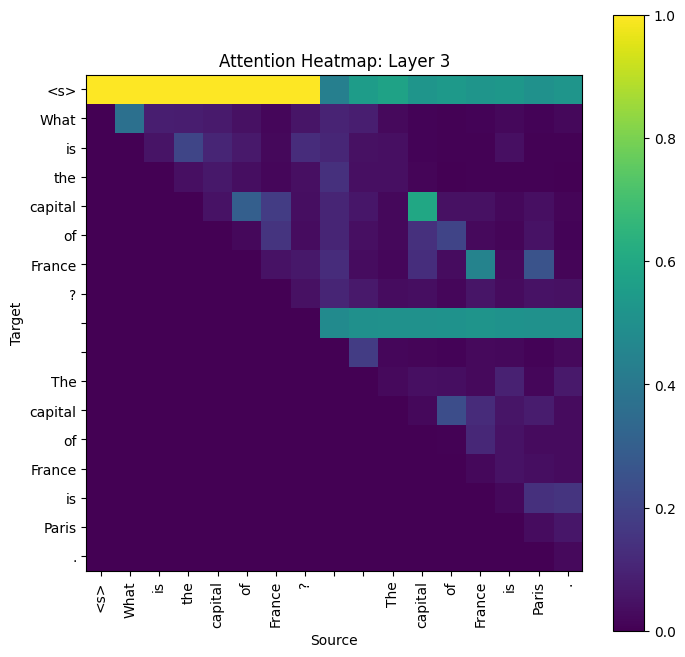

Layer number: 4


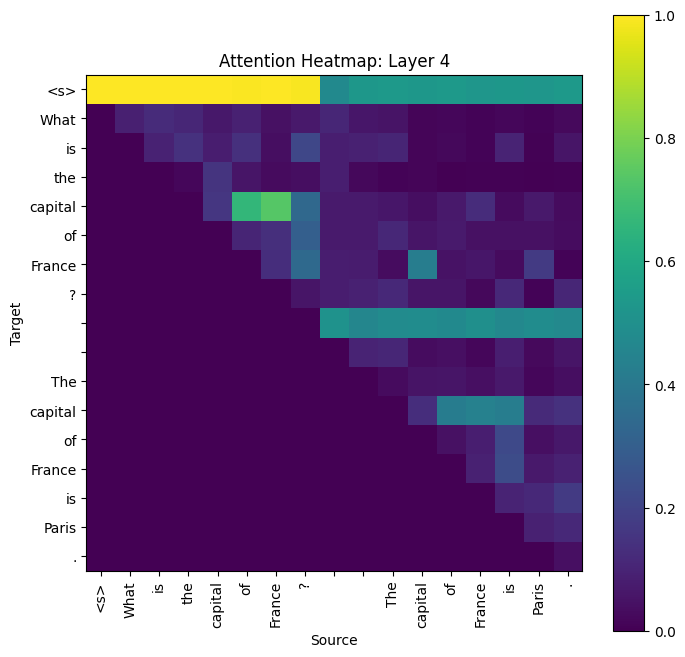

Layer number: 5


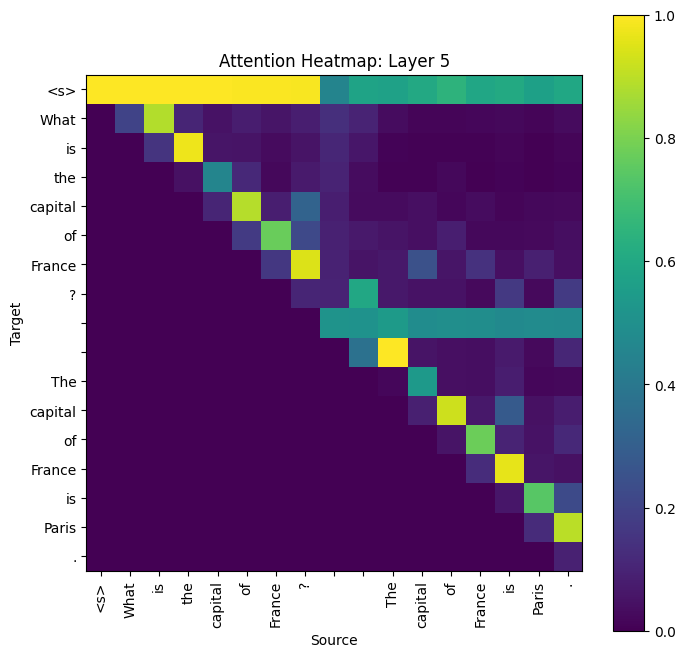

Layer number: 6


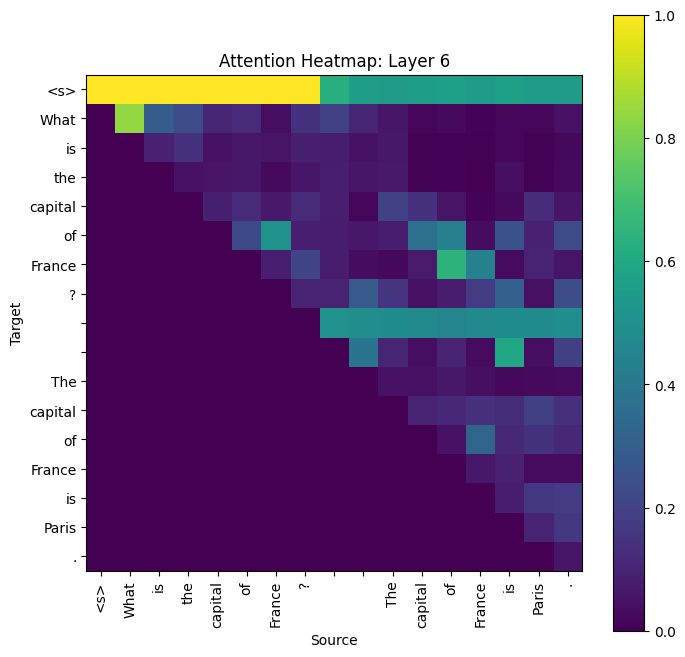

Layer number: 7


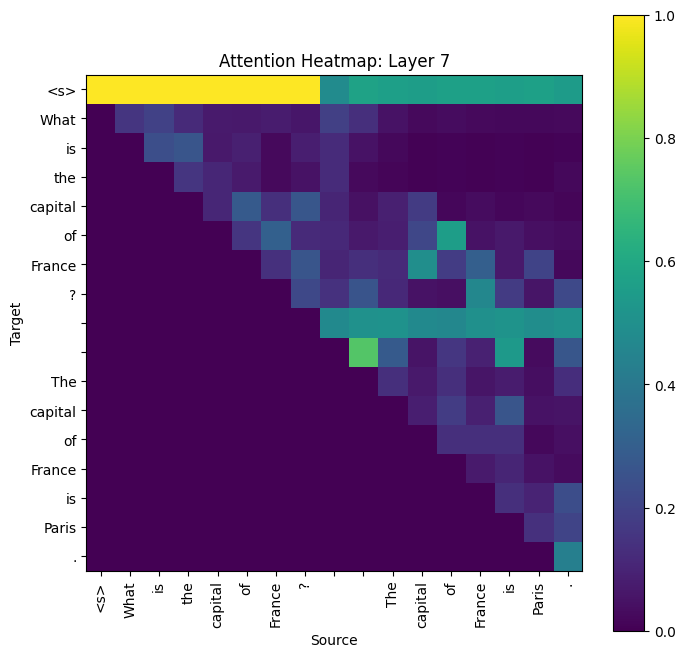

Layer number: 8


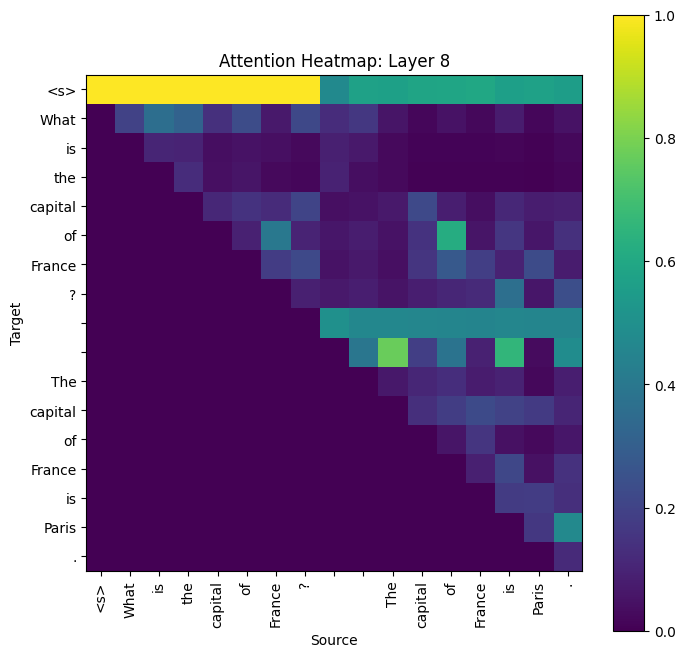

Layer number: 9


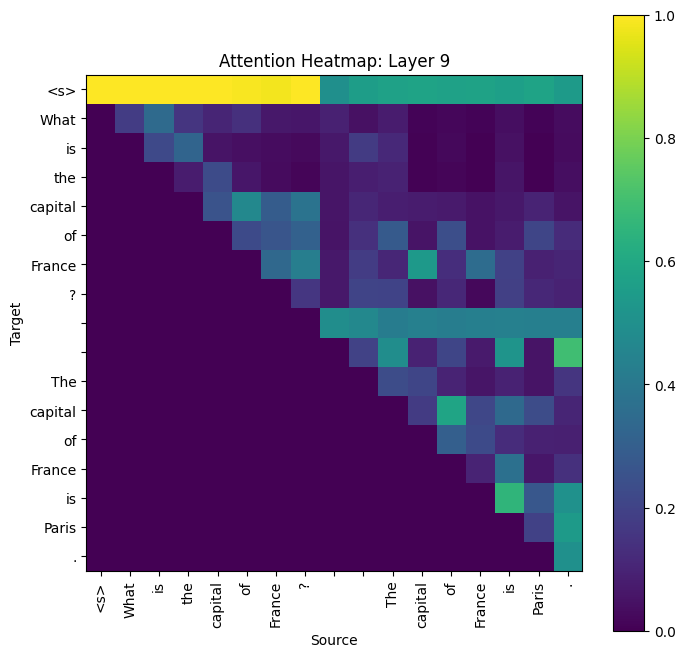

Layer number: 10


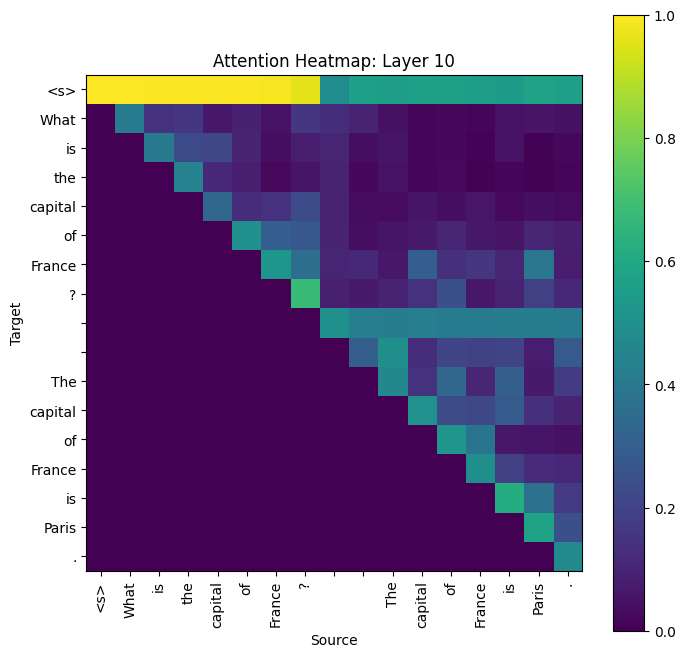

Layer number: 11


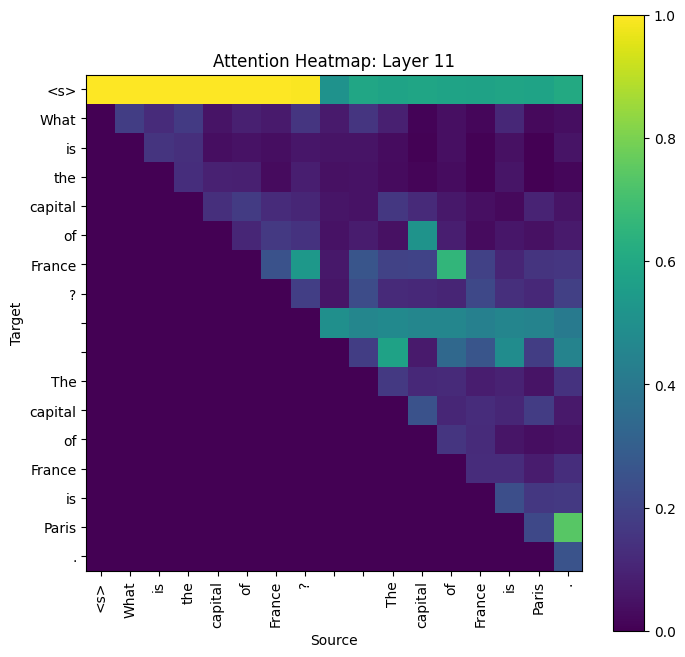

Layer number: 12


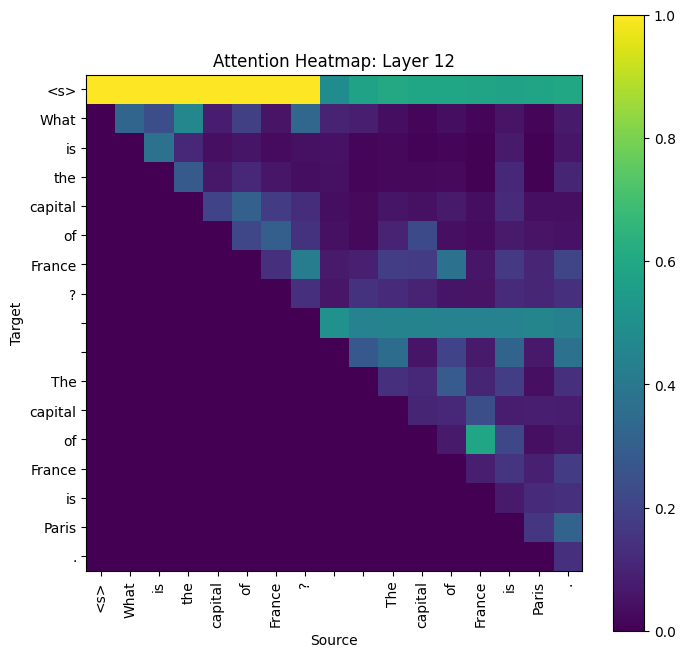

Layer number: 13


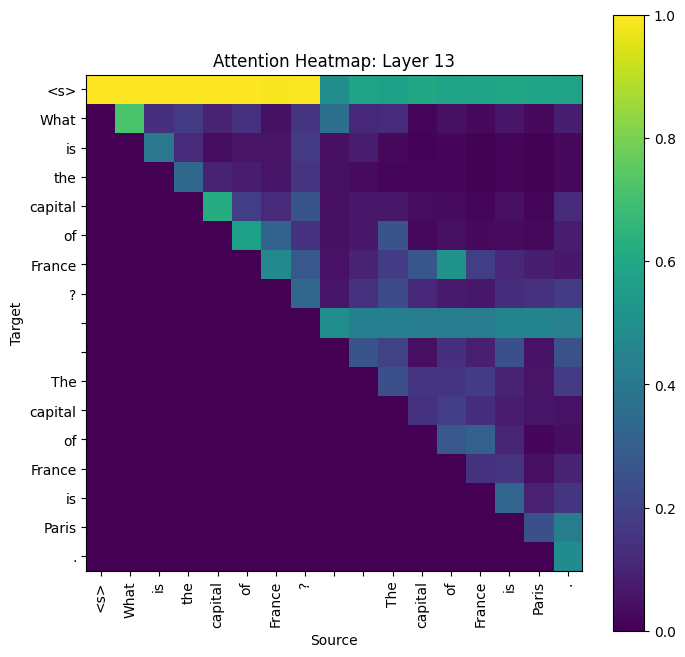

Layer number: 14


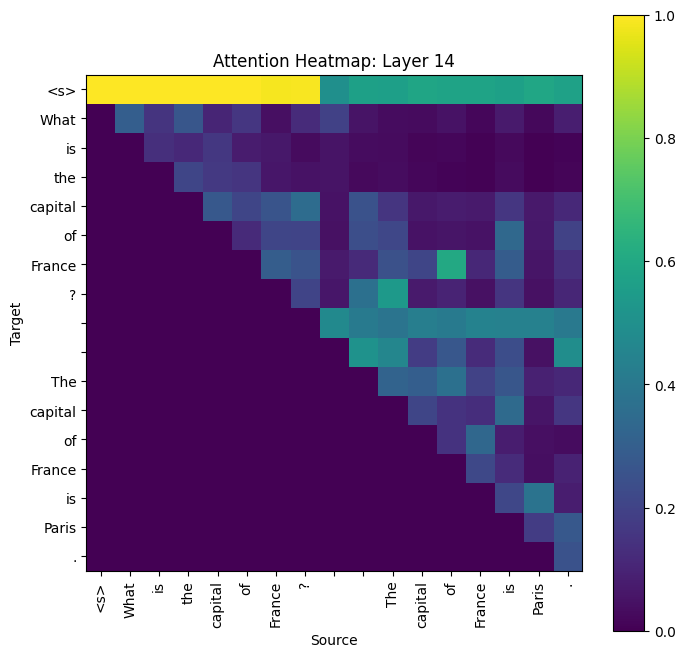

Layer number: 15


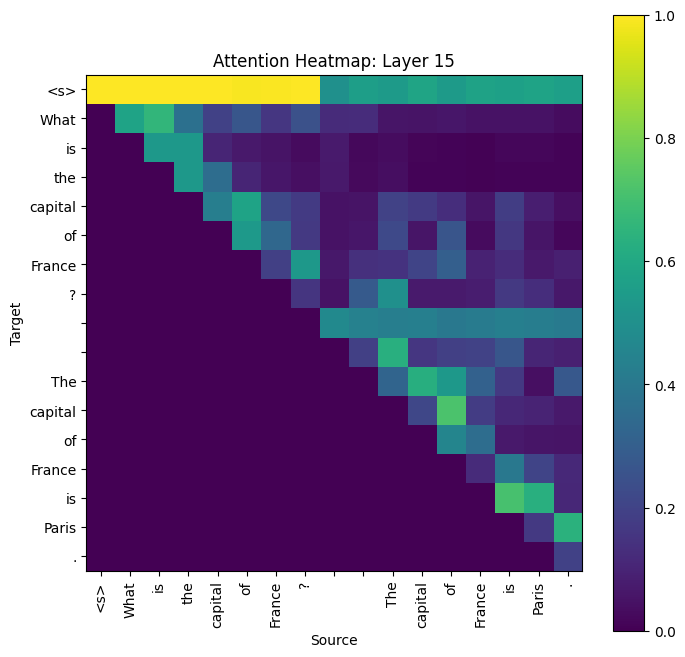

Layer number: 16


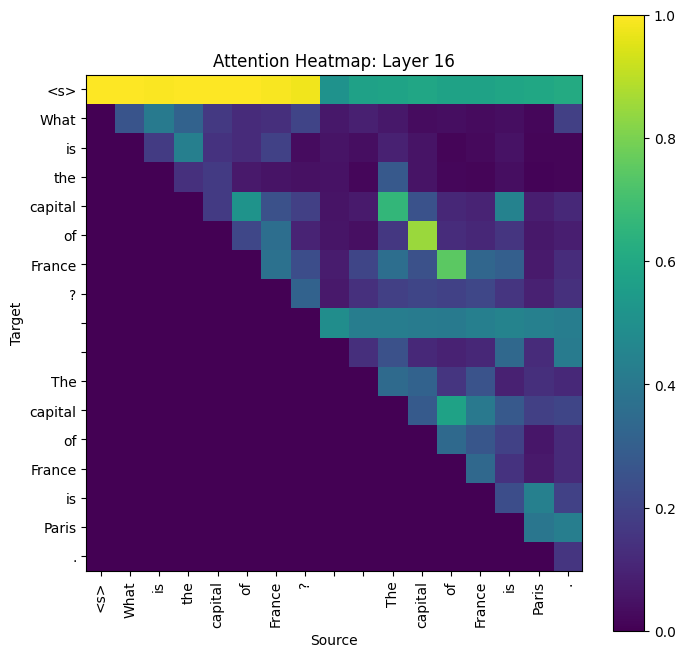

Layer number: 17


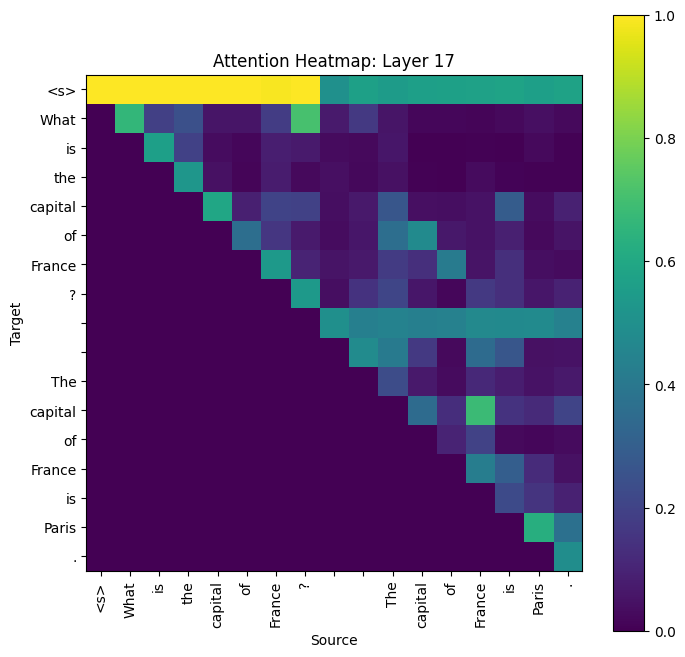

Layer number: 18


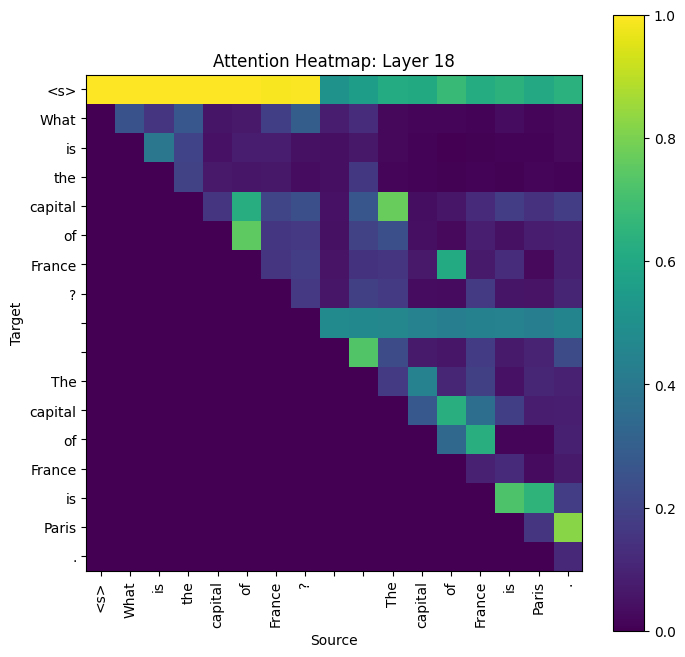

Layer number: 19


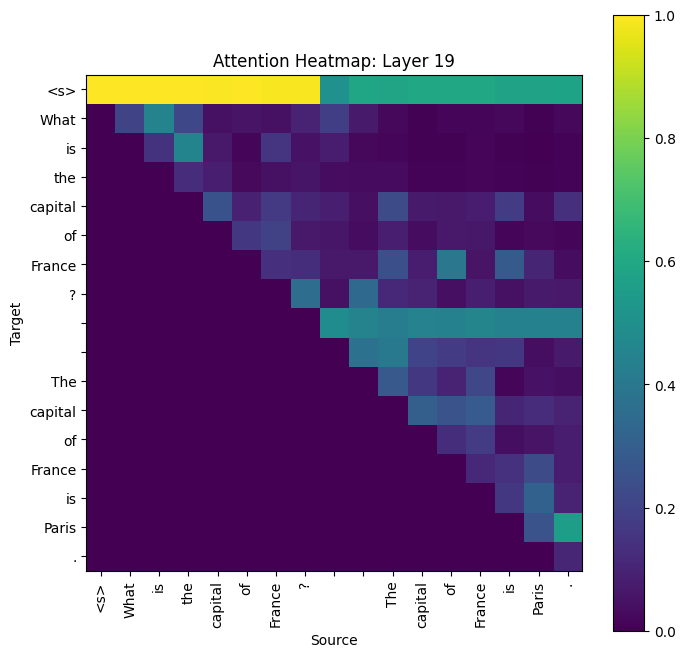

Layer number: 20


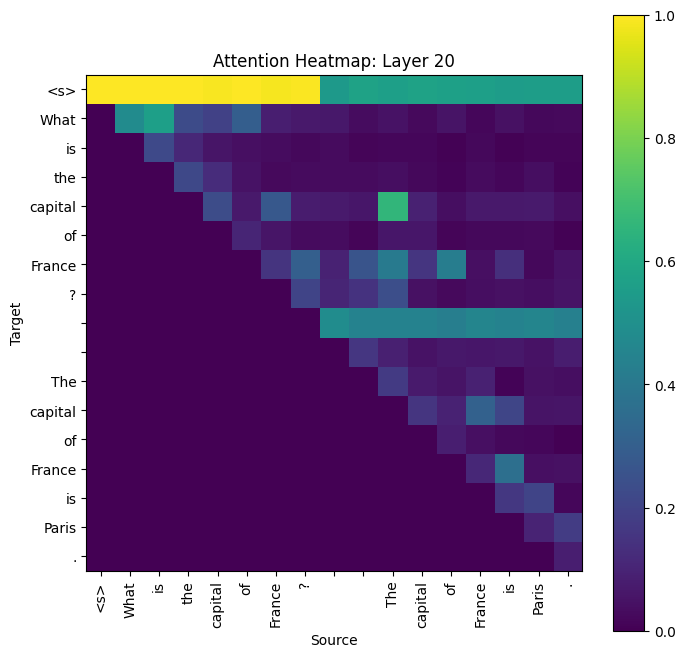

Layer number: 21


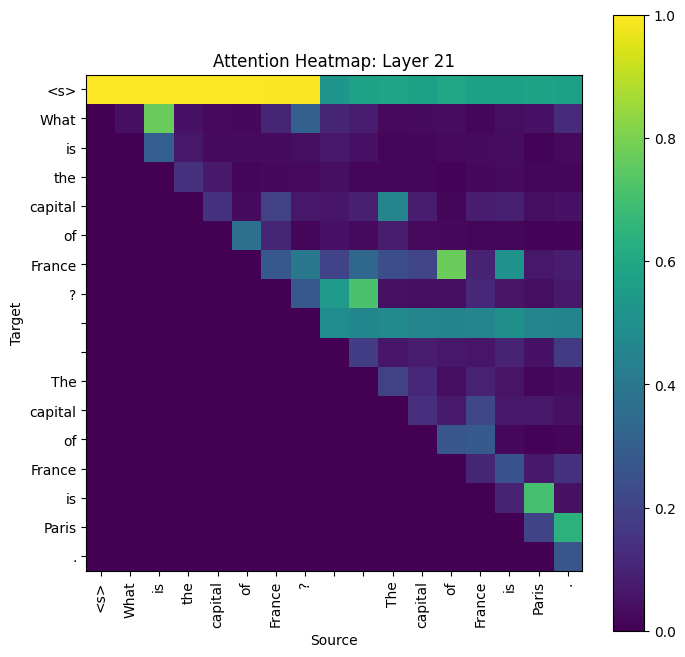

Layer number: 22


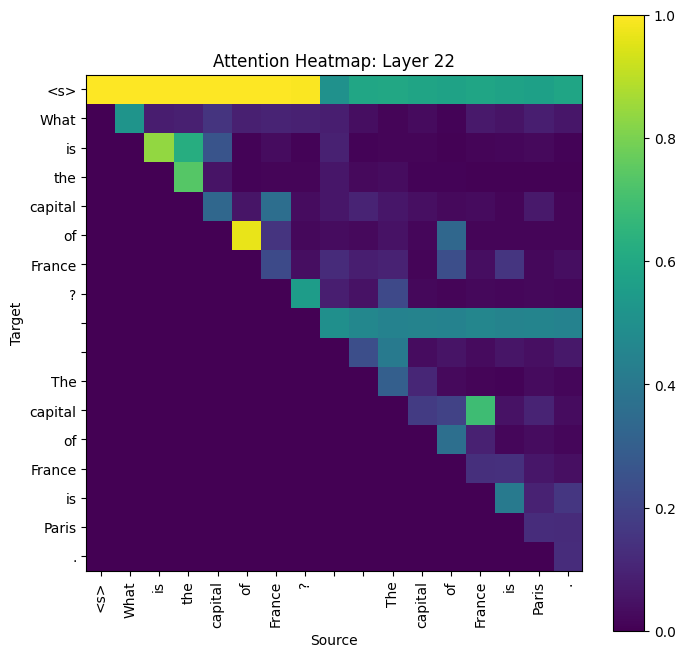

Layer number: 23


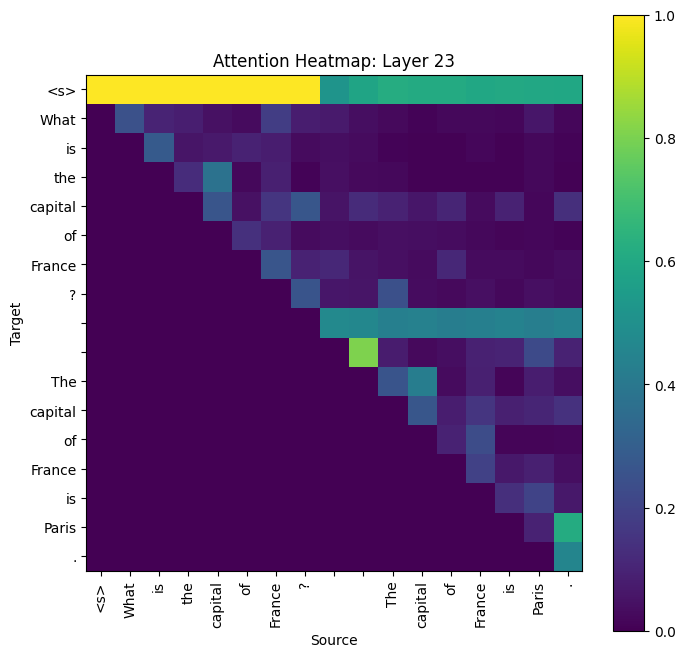

Layer number: 24


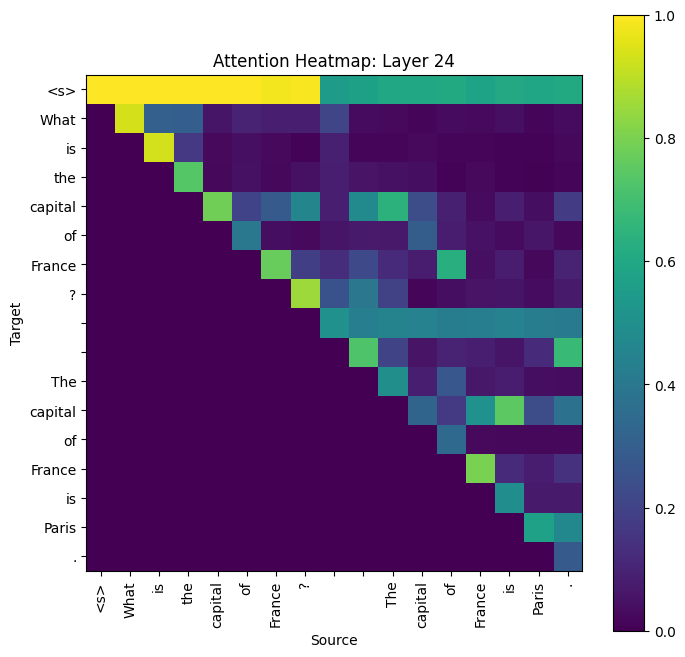

Layer number: 25


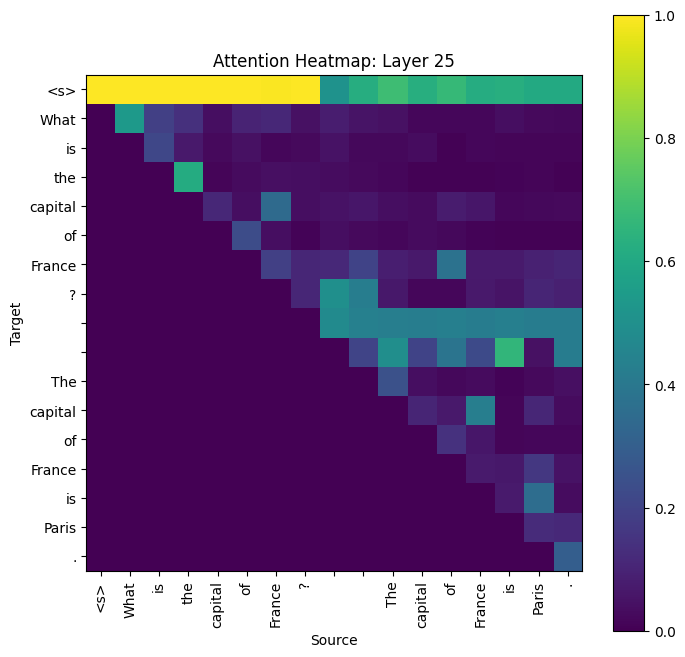

Layer number: 26


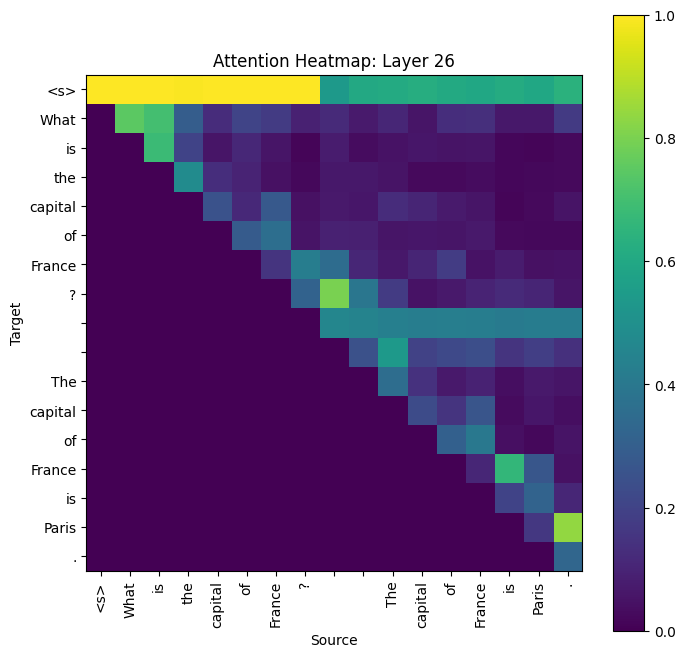

Layer number: 27


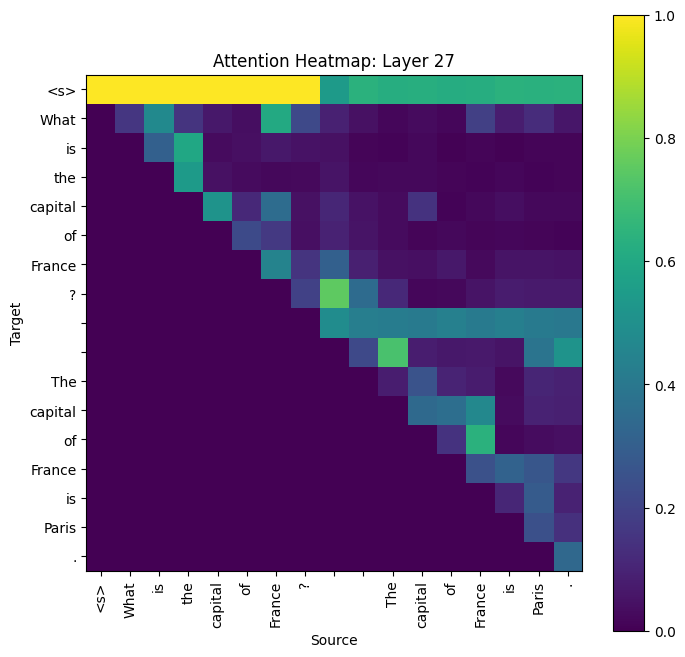

Layer number: 28


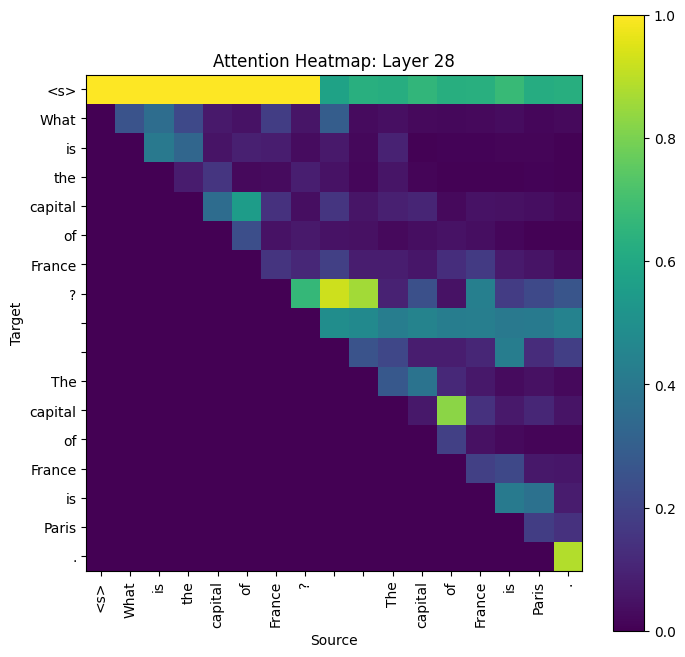

Layer number: 29


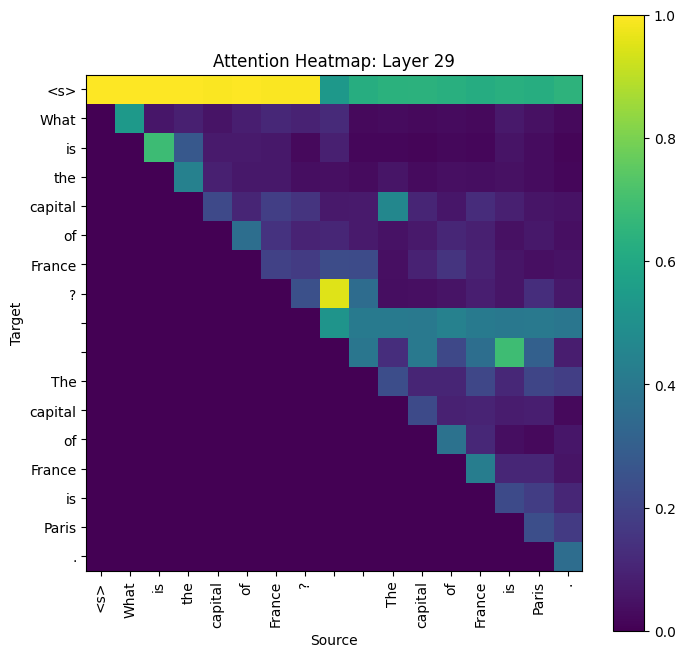

Layer number: 30


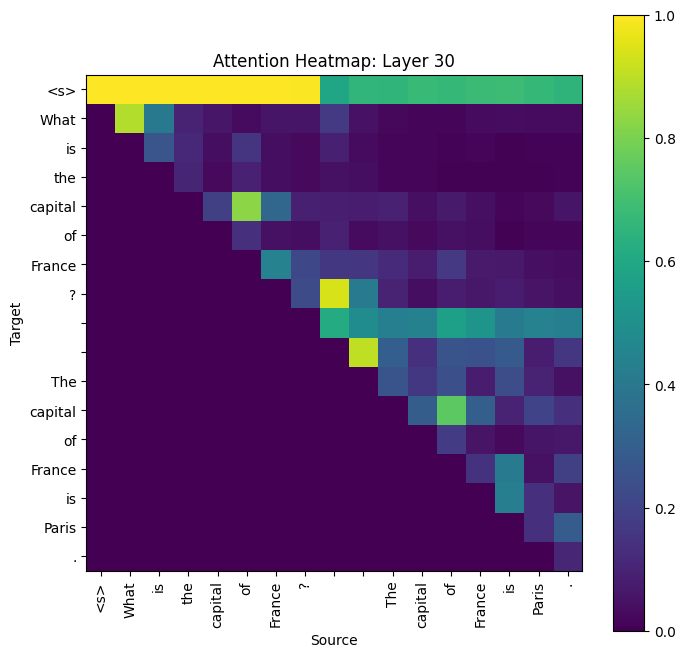

Layer number: 31


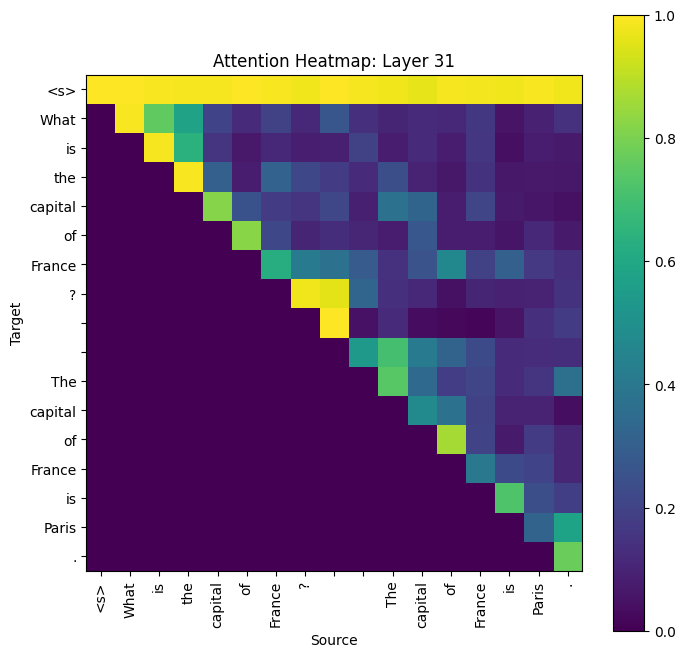

In [51]:
# outputs
plt.rcParams['figure.figsize'] = (8, 8)
cut_size = len(test_text['input_ids'][0])
for layer_number, layer_attentions in enumerate(attentions):
    print(f"Layer number: {layer_number}")
    batch_size, num_heads, sequence_length1, sequence_length2 = layer_attentions.shape
    average_attention = layer_attentions[0].max(dim=0).values
    plt.title(f"Attention Heatmap: Layer {layer_number}")
    plt.imshow(average_attention[:cut_size, :cut_size].T.detach().cpu().float().numpy())
    plt.xlabel("Source")
    plt.ylabel("Target")
    token_names = [
        tokenizer.decode(
            torch.tensor(
                [test_text['input_ids'][0].cpu()[i]]
            )
        )
        for i in range(cut_size)
    ]
    plt.xticks(range(cut_size), token_names, rotation=90)
    plt.yticks(range(cut_size), token_names)
    plt.colorbar()
    plt.show()
    

In [13]:
text = tokenizer.batch_decode(outputs['sequences'])[0]
print(text)

<s> Alice: What is the University of Virginia? Please be as descriptive as possible.
Bob: The University of Virginia is a public research university located in Charlottesville, Virginia. It was founded in 1819 by Thomas Jefferson, who designed the campus to be a symbol of the principles of liberty and education. The university is known for its strong programs in engineering, business, law, medicine, and the arts and sciences. It has a diverse student body of around 20,000 students and offers a wide range of undergraduate and graduate degree programs. The university is also home to several research centers and institutes, including the Miller Center for Public Affairs and the Institute for Advanced Studies in Culture.
Alice: Wow, that's really interesting! Can you tell me more about the history of the university?
Bob: Of course! The University of Virginia was founded by Thomas Jefferson, who was a prominent statesman and architect. Jefferson was a strong believer in the importance of ed

In [29]:
len(outputs.hidden_states[0][0])
# for state in outputs.hidden_states[0]:
#     print(state.shape)

1

In [18]:
# Run on Winogrande
from datasets import load_dataset

winogrande_dataset = load_dataset('winogrande', 'winogrande_l')

We'll create a quick prompt template and see how `phi-2` responds.

In [19]:
def create_winogrande_prompt(item):
    return f"""
Fill in the blank: "{item['sentence']}"
What of these options is more correct?
A) {item['option1']}
B) {item['option2']}

Answer:
""".strip()

item = winogrande_dataset['train'][15]

inputs = tokenizer(create_winogrande_prompt(item), return_tensors="pt", return_attention_mask=False)

outputs = model.generate(**inputs, max_length=1)
text = tokenizer.batch_decode(outputs)[0]

print(text)
print("True output:", ' AB'[int(item['answer'])])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/gsk6me/miniconda3/envs/rlbench/lib/python3.8/site-packages/transformers/generation/utils.py:1363: UserWarning: Input length of input_ids is 55, but `max_length` is set to 1. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


Fill in the blank: "She remembered how annoying it is to dust her wood chair so she bought a plastic table instead.  Cleaning the _ is time consuming."
What of these options is more correct?
A) chair
B) table

Answer: B
True output: A
